# PP Attachment

The Preposition Phrase attachment problem is the difficulty to decide if a preposition in a sentence is attached to a verb or a noun.

In some cases it may even confuse the reader. For example, the sentence:

> San Jose cops kill man with a knife

can be interpreted as either the man or the cops were holding a knife. The difference in the syntax parsing would be attaching the preposition phrase -

either to the **Verb** Phrase ("kill with knife")

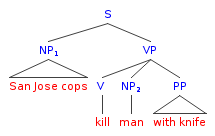

or to the **Noun** Phrase ("man with knife").

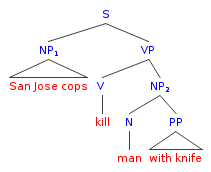


Let's try out the Preposition Phrase attachment classification!

Through this exercise, you'll practice classification of linguistic aspects of text.

# Setup
Loading the data

In [ ]:
import csv

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB



In [ ]:
def read_pp_examples(file_url: str) -> List[Dict]:
  """Reads the pp samples from a remtoe url and loads them into a dictionary

  Args:
      file_url (str): a url to load the dataset from

  Returns:
      Dict: a dictionary with two keys: answer and pp
  """
  pp_examples = []

  for line in tqdm(urlopen(file_url)):
    line = line.decode("utf-8").strip().split()
    assert(len(line) == 5)
    v,n1,p,n2,answer = line
    pp_examples.append( {'answer':answer,'keywords':(v,n1,p,n2)} )
  return pp_examples

In [ ]:
pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'

In [ ]:
pp_examples = read_pp_examples(pp_samples_url)


0it [00:00, ?it/s]

# Step #1 - Look at the data

Step 1 is (always) to examine the data!

That means to check the data statistics, load some sample at random and ensure it is correctly labeled, and if possible, plot and visualize the data (histograms, distribution, etc.).

In [ ]:
print(f"There are {len(pp_examples)} samples in the dataset")

There are 25858 samples in the dataset


Let's peek in some random sample:

In [ ]:
print(choice(pp_examples))

{'answer': 'N', 'keywords': ('reflecting', 'costs', 'for', 'stake')}


Of course, we can reach the dictionary's parts by specifying the key in a squared brackets.

In [ ]:
random_example = choice(pp_examples)
random_example['keywords']

('cited', 'parallels', 'between', 'case')

In [ ]:
random_example['answer']

'N'

This is obviously not enough "looking at the data"...

There are two main options to explore at the data:
1. Reduce the data dimensionality to 2D or 3D and plot it (PCA, SVD, U-Map, etc.)
2. Answer statistical questions about the data (what is the distribution of..., how many ... are there, etc.).

**1) How many examples we have per group N and V?**

In [ ]:
df = pd.DataFrame(pp_examples)
grouped_df = df.groupby('answer').count()
grouped_df

,keywords
answer,
N,14094
V,11764


The dataset is not equally devided, but I think the difference doesn't influance our analysis so much.

**2) What pp do we have and how are they is the distribution between groups N and V?**

In [ ]:
df = pd.DataFrame(pp_examples)
df['keywords'] = [example[2] for example in df['keywords']]
df['answer_V'] = df['answer'].apply(lambda x: 1 if x == 'V' else 0)
df['answer_N'] = df['answer'].apply(lambda x: 1 if x == 'N' else 0)

#group by the PP
grouped_df = df[['keywords','answer_N','answer_V']].groupby('keywords').sum().sort_values('answer_V', ascending=False).reset_index()
grouped_df


,keywords,answer_N,answer_V
0,in,2005,2423
1,to,634,2120
2,for,1557,1206
3,from,499,1150
4,on,803,800
...,...,...,...
66,versus,1,0
67,besides,1,0
68,vs.,1,0
69,From,1,0


We can see that some PP like 'for' and 'from' appears two times, because data is not unification.

Let's do the small cleaning:

In [ ]:
df = pd.DataFrame(pp_examples)
# change the letters to lower
df['keywords'] = [example[2].lower() for example in df['keywords']]
df['answer_V'] = df['answer'].apply(lambda x: 1 if x == 'V' else 0)
df['answer_N'] = df['answer'].apply(lambda x: 1 if x == 'N' else 0)
grouped_df = df[['keywords','answer_N','answer_V']].groupby('keywords').sum().sort_values('answer_V', ascending=False).reset_index()
grouped_df


,keywords,answer_N,answer_V
0,in,2005,2425
1,to,634,2120
2,for,1559,1206
3,from,500,1150
4,on,803,801
...,...,...,...
60,aboard,0,1
61,unto,1,0
62,besides,1,0
63,versus,1,0


After unification there are 65 differet PP.

I will present them on the graph:

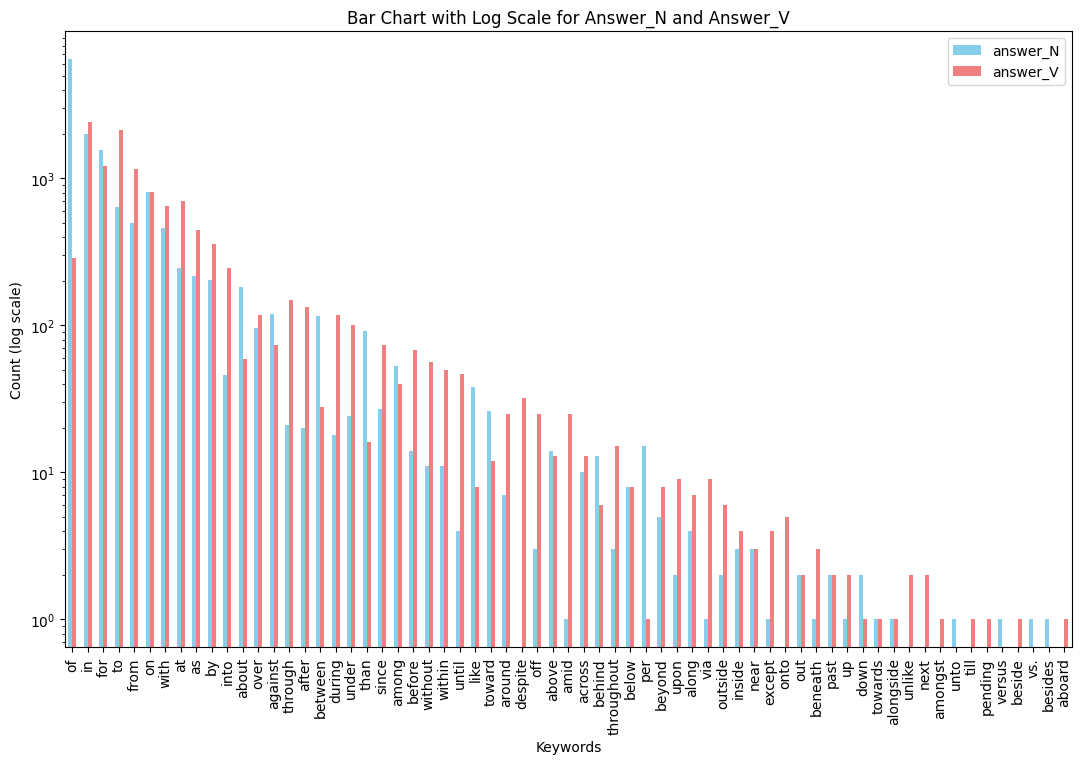

In [ ]:
#dataframe of PP and their frequency in the dataset
df['total_answer'] = df['answer_N'] + df['answer_V']
grouped_df = df[['keywords','answer_N','answer_V', 'total_answer']].groupby('keywords').sum().sort_values('total_answer', ascending=False).reset_index()

grouped_df.set_index('keywords', inplace=True)

# Plot the bar chart with log scale on the y-axis
ax = grouped_df[['answer_N','answer_V']].plot(kind='bar', logy=True, figsize=(13, 8), color=['skyblue', 'lightcoral'])
ax.set_ylabel('Count (log scale)')
ax.set_xlabel('Keywords')
ax.set_title('Bar Chart with Log Scale for Answer_N and Answer_V')

plt.show()

From the chart, we can see that the more common PPs in our data are: **of, in, for, to, from, on, with**. Most of the time, each of the PPs is used in both options, in relation to both V and N. However, it's not equally divided between groups.

# PCA

I also attempted to create a graphical representation of the data using Principal Component Analysis (PCA).

The planned workflow was as follows:

1. Convert sets of keywords to a single string.
2. Create vector representations of the strings using the `TfidfVectorizer` function using ngrams (1,1).
3. Apply PCA on the vectorized data.
4. Attempt to visually represent the distribution of two groups (V and N) in the resulting space.
5. Explore the distribution in space of the 10 most frequent prepositional phrases (PP).
6. Investigate if there is an option to distribute prepositional phrases based on their assignment to one of the groups (V and N).


In [ ]:
#PCA

# Convert keywords into text
df = pd.DataFrame(pp_examples)
df['text_keywords'] = df['keywords'].apply(lambda x: ' '.join(x))

# TF-IDF vectorization
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,1))
X = vectorizer.fit_transform(df['text_keywords'])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
X_pca.shape

(25858, 2)

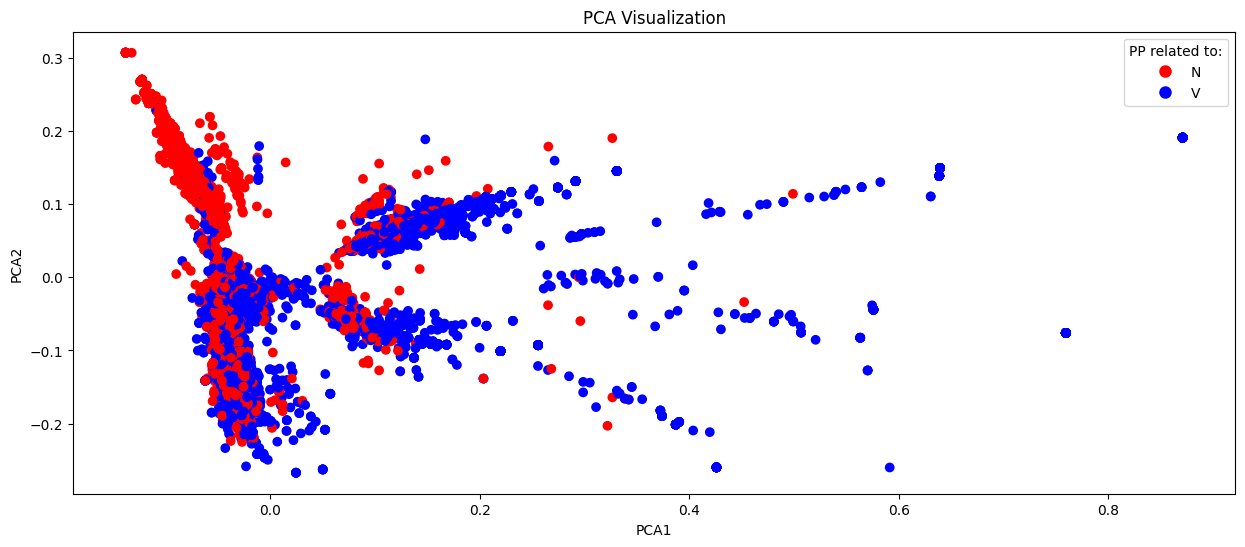

In [ ]:
# Combine PCA components with the target variable 'answer'
df_pca = pd.DataFrame(data={'answer': df['answer'], 'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1],
                            'sentence': df['text_keywords'], 'pp': df['text_keywords'].apply(lambda x: x.split()[2])})

# Plot the PCA visualization
plt.figure(figsize=(15, 6))
scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'],
                      c=df_pca['answer'].map({'N': 'red', 'V': 'blue'}))

# Create a legend for the plot
legend_labels = {'N': 'red', 'V': 'blue'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markerfacecolor=color, markersize=10) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='PP related to:', loc='upper right')

# Set plot title and axis labels
plt.title('PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Display the plot
plt.show()

Based on the graph, we cannot identify a clear line that separates the prepositional phrases (PP) related to verbs (V) from those related to nouns (N). It appears that PP related to N are situated slightly more to the left in the space.

Additionally, we observe that the data exhibits an interesting "sunny-like" shape.

To analyze it further, I attempted to visualize the distribution of the space for the 10 most frequently used prepositional phrases in the dataset:


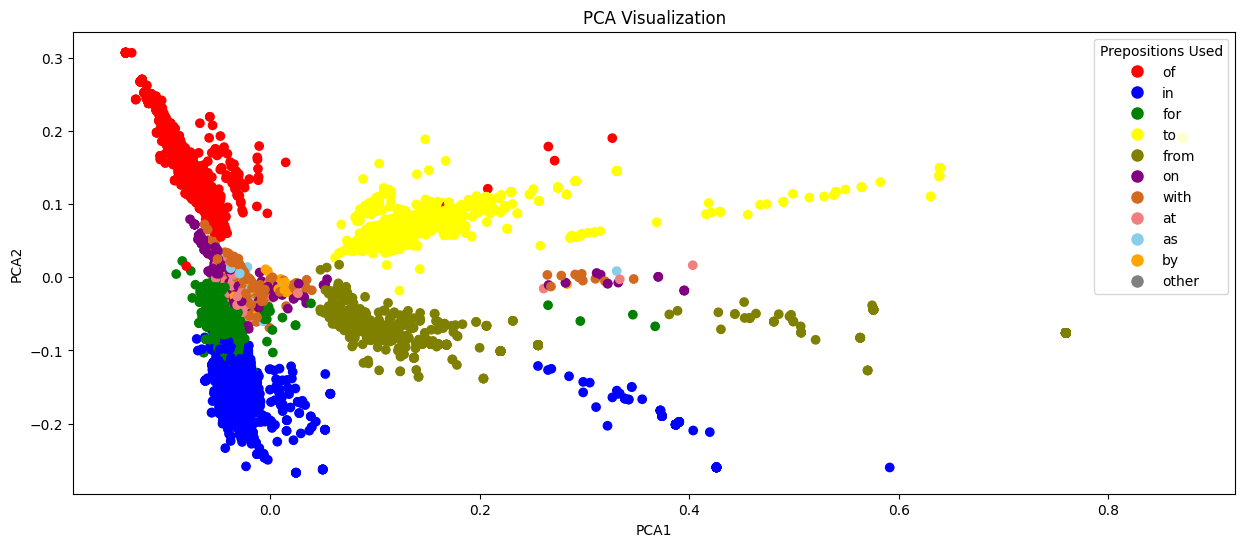

In [ ]:
# Define the word list with their corresponding RGB colors for the labels on the graph
word_list = dict([
    ('of', 'red'),
    ('in', 'blue'),
    ('for', 'green'),
    ('to', 'yellow'),
    ('from', 'olive'),
    ('on', 'purple'),
    ('with', 'chocolate'),
    ('at', 'lightcoral'),
    ('as', 'skyblue'),
    ('by', 'orange'),
    ('other', 'grey')
])

# Create a scatter plot for PCA visualization with different colors for each prepositional phrase (PP)
plt.figure(figsize=(15, 6))
scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['pp'].map(word_list).fillna('chocolate'))

# Create a legend for the plot
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                            markerfacecolor=color, markersize=10) for label, color in word_list.items()]
plt.legend(handles=legend_labels, title='Prepositions Used', loc='upper right')

# Set plot title and axis labels
plt.title('PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Display the plot
plt.show()


The graph illustrates that we can cluster the data to identify distinct regions in the space that characterize specific prepositions.

To verify if we can distinguish the space for each preposition based on whether they are related to nouns (N) or verbs (V):


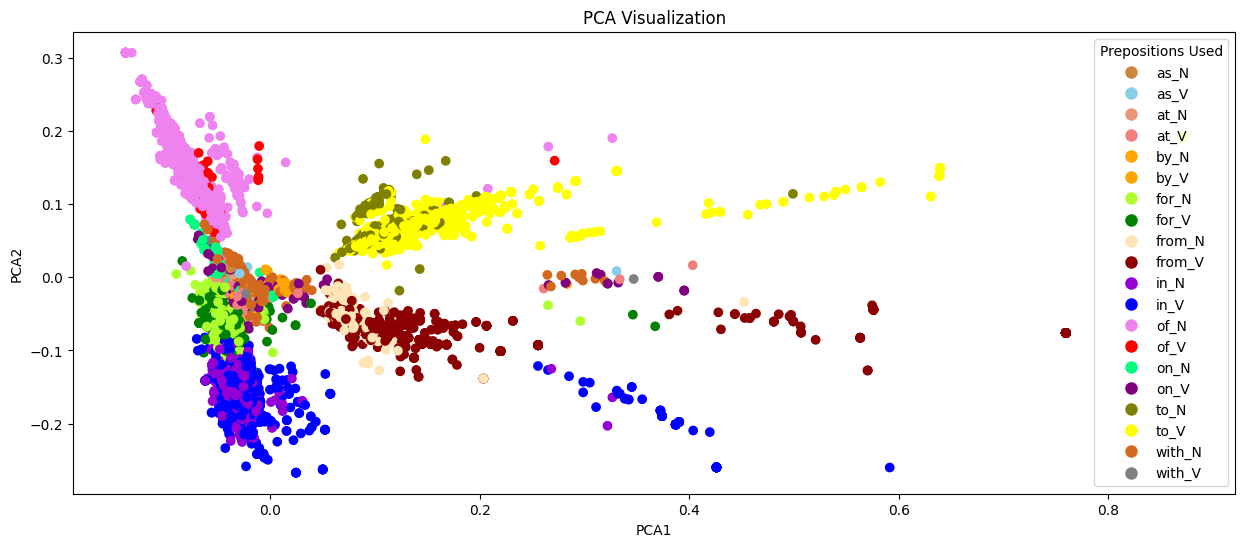

In [ ]:
# Define the word list with their corresponding RGB colors
word_list = dict([
    ('as_N', 'peru'),
    ('as_V', 'skyblue'),
    ('at_N', 'darksalmon'),
    ('at_V', 'lightcoral'),
    ('by_N', 'orange'),
    ('by_V', 'orange'),
    ('for_N', 'greenyellow'),
    ('for_V', 'green'),
    ('from_N', 'moccasin'),
    ('from_V', 'darkred'),
    ('in_N', 'darkviolet'),
    ('in_V', 'blue'),
    ('of_N', 'violet'),
    ('of_V', 'red'),
    ('on_N', 'springgreen'),
    ('on_V', 'purple'),
    ('to_N', 'olive'),
    ('to_V', 'yellow'),
    ('with_N', 'chocolate'),
    ('with_V', 'grey')
])

# Combine 'pp' with 'answer' to create unique labels
df_pca['pp'] = df_pca['pp'] + '_' + df_pca['answer']

# Create a scatter plot for PCA visualization with different colors for each prepositional phrase (PP)
plt.figure(figsize=(15, 6))
scatter = plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['pp'].map(word_list).fillna('chocolate'), alpha=1)

# Create a legend for the plot
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                            markerfacecolor=color, markersize=10) for label, color in word_list.items()]
plt.legend(handles=legend_labels, title='Prepositions Used', loc='right')

# Set plot title and axis labels
plt.title('PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Display the plot
plt.show()

The graph appears a bit chaotic (after the first glance, especialy in the middle part, where so many colors overlap), but it seems that there there can by a distinction in placement depending on whether the prepositional phrase (PP) is in relation to a verb (V) or a noun (N).

For example, for the PP **"to" and "from"**, we can observe that when the PP is related to N, it is shifted more towards the left part of the space.


# Step 2: Deciding on the measurement

In [ ]:
# we can split the dataset simply through dividing the list

amt = int(0.75 * len(pp_examples))
train_examples, test_examples = pp_examples[:amt], pp_examples[amt:]

print(f"training data size: {len(train_examples)}, test data size: {len(test_examples)}")

training data size: 19393, test data size: 6465


We'll define a classifier evaluator.

Given a set of examples and an evaluator, it just returns the accuracy score

In [ ]:
def evaluate_classifier(examples, pp_resolver):
  """evaluate the classifier and returns the accuracy score.

  Args:
      examples (List): a list of {'keywords':(v,n1,p,n2), 'answer':answer }
      pp_resolver (_type_): a model with a classify() function that maps from
        (v,n1,p,n2) to 'N' / 'V'

  Returns:
      float: The accurcy score of the classifier
  """
  correct = 0.0
  incorrect = 0.0
  for example in examples:
      answer = pp_resolver.classify(example['keywords'])

      if answer == example['answer']:
          correct += 1
      else:
          incorrect += 1
  return correct / (correct + incorrect)


# Classifiers

Let's test it on an extremely naive classifiers:

In [ ]:
class AlwaysSayN:
    """
    This naive clasifier answers always with 'Noun'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'N'


In [ ]:
class AlwaysSayV:
    """
    This naive clasifier answers always with 'Verb'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'V'


In [ ]:
evaluate_classifier(test_examples, AlwaysSayV())

0.4634184068058778

In [ ]:
evaluate_classifier(test_examples, AlwaysSayN())

0.5365815931941222

We can see that saying always '**Noun**', leads to an accuracy result of 53%.

---

We can also see that our dataset is relatively balaneced (46-53)

We could, instead, have tested which class has the majority and simply select it:

In [ ]:
class MajorityClassResolver:
  """
  This classifier tests during initialization which of the classes is the
  bigger one (N or V), stores the result and always returns it.
  """

  def __init__(self, training_examples: List):
    """Tests which class is the majority and saves it as a class property.

    Args:
        training_examples (List): A list of dictionary training examples.
    """
    answers = [item['answer'] for item in training_examples]
    num_n = len([a for a in answers if a == 'N'])
    num_v = len([a for a in answers if a == 'V'])
    if num_v > num_n:
        self.answer = 'V'
    else:
        self.answer = 'N'

  def classify(self, pp: Tuple) -> str:
    """classify a 4 keywords tuple as N or V attachment, based on the previously calculated majority class

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    #print(self.answer)
    return self.answer


In [ ]:
evaluate_classifier(test_examples, MajorityClassResolver(train_examples))

0.5365815931941222

We can make it a bit more sophisticated by peeking at the training examples:

In [ ]:
class LookupResolver:
  def __init__(self, training_examples: List):
    """
    Initializes the class, load all the training dataset into the memory and
    during prediction, return the answer if the keywords match a previously
    saved one.

    Args:
        training_examples (List): _description_
    """
    self.answers = {}
    for item in training_examples:
        self.answers[item['keywords']] = item['answer']
    self.backoff = MajorityClassResolver(training_examples)

  def classify(self, pp: Tuple) -> str:
    """Classify a 4 keywords tuple as N or V attachment.
     If the tuple was found in the previously stored answers, return it.
     Otherwise, return the majority class.

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    if pp in self.answers:
        return self.answers[pp]
    else:
        return self.backoff.classify(pp)

## logic: if pp in trainng data then take the answer directly form there, the other way used MajorityClassResolver

In [ ]:
# If you want to understand what is stored in the `answers` property, uncomment and run the following line:
#LookupResolver(train_examples).answers

In [ ]:
evaluate_classifier(test_examples, LookupResolver(train_examples))

0.6009280742459396

# Explore and classify:

Implement a discriminative PP-attachment model, using a classifier of your choice (i.e. - Naive Bayes Classifier https://web.stanford.edu/~jurafsky/slp3/4.pdf, [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), etc.) from a toolkit such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Possible features:

Single items ​
* Identity of v ​
* Identity of p ​
* Identity of n1 ​
* Identity of n2 ​

Pairs:​
* dentity of (v, p) ​
* Identity of (n1, p) ​
* Identity of (p, n1)​

Triplets:​
* Identity of (v, n1, p)​
* Identity of (v, p, n2) ​
* Identity of (n1, p, n2) ​

Quadruple:​
* Identity of (v, n1, p, n2)​


> Note: The following advanced features require some external English dataset.

Corpus Level:​
* Have we seen the (v, p) pair in a 5-word window in some big corpus?​
* Have we seen the (n1, p) pair in a 5-word window in some big corpus? ​
* Have we seen the (n1, p, n2) triplet in a 5-word window in a big corpus?​
*  Variation: instead of binary features, you can use counts, or binned counts.​

Distance:​
* Distance (in words) between v and p ​
* Distance (in words) between n1 and p​

---

- For the Corpus Level features, you can load one of the english corpuses in NLTK (such as [brown - but don't forget to download it first](https://www.nltk.org/book/ch02.html)). If you use a tagged corpus - such that the words are tagged by their parts of speech, you can create more interesting linguistic-related features.

- You can also consider using [WordNet](https://wordnet.princeton.edu/), a large *lexical* database of English words, which is also [implemented in NLTK](https://www.nltk.org/howto/wordnet.html).

- Alternatively, you could try using Word-Embedding, such as [BPEmb](https://bpemb.h-its.org/), followed by a classifier to your choice.

- Finally, if you need inspiration and ideas, here are some selected papers:
  - [An Analysis of Prepositional-Phrase Attachment Disambiguation](http://ejournals.asia/stj1/ijclr2.pdf) - an overview of different papers dealing with this problem using different methods (kNN, SVN, etc.).
  - [The spy saw a cop with a telescope: Who has the telescope?](https://www.semanticscholar.org/paper/The-spy-saw-a-cop-with-a-telescope%3A-Who-has-the-Yan-Nguyen/3220ad0619b72404cb9b1acb9e093a8a564f0f4e) - An linguistic analysis of the potentials reasons (and features) to disambiguify pp attachment.
  - [PREPOSITIONAL PHRASE ATTACHMENT AMBIGUITY RESOLUTION USING SEMANTIC HIERARCHIES](https://eprints.mdx.ac.uk/2471/1/ppattachhier.pdf)
  - [Corpus Based PP Attachment Ambiguity Resolution with a Semantic Dictionary](https://aclanthology.org/W97-0109.pdf)

# Search for the best hyperparameters - **GridSearch**
I decided to test different model with the basic parameters.

Descriptions of the models I choose:

**Vectorization Methods:**

* **CountVectorizer():** Utilized to convert sets of keywords into numerical vectors, capturing word frequencies. This method is particularly useful in representing the presence or absence of words in the context of prepositional phrase (PP) classification.

* **TfidfVectorizer():** Employed to convert sets of keywords into numerical vectors, considering term frequencies. This method weighs the importance of words in the PP context, providing a more nuanced representation.

-> to create different features i used parapeter *'ngram_range'* in each of the Vectorizers.

`ngram_range` determines the range of n-grams (contiguous sequences of words) considered during the tokenization process. For example, with `ngram_range=(1, 1)`, only unigrams (single words) are considered. Increasing the range, such as with `ngram_range=(1, 2)`, includes both unigrams and bigrams. Further extensions, like `ngram_range=(1, 3)` for triplets or `(1, 4)` for quadruples, progressively capture more contextual information. I explore different values for this parameter to optimize the model for my specific task.


--------------------------------------------------------------

**Classification Models:**

* **SVC()**: A robust classifier suitable for PP classification tasks, effective in capturing complex relationships within high-dimensional spaces.

* **KNeighborsClassifier():** Chosen for its simplicity and effectiveness in capturing local patterns, making it suitable for identifying patterns in PP usage.

* **RandomForestClassifier():** Employed as an ensemble model of decision trees to enhance accuracy and robustness, contributing to improved PP classification results.

* **ComplementNB()** and **MultinomialNB():** Naive Bayes models specifically designed for text classification, considered for their ability to handle sparse datasets like those common in PP contexts.

------------------------------------------------------------
PS: I should mention that I've never created a class for hyperparameter tuning before, so I'm not certain if it adheres to the necessary conventions. I would greatly appreciate any suggestions on how to better structure the classes. /Zosia

In [ ]:
#parameter:

#vectorizers
cvr = ('cvr', CountVectorizer())
tf_idf = ('tf_idf', TfidfVectorizer())

#models
svc = ('svc', SVC())
knn = ('knn', KNeighborsClassifier())
rf = ('rf', RandomForestClassifier())
cnb = ('cnb', ComplementNB())
mnb = ('mnb', MultinomialNB())

#params
cvr_param_grid = dict(cvr__ngram_range=[(1,1),(1,2),(1,3),(1,4)])
tf_idf_param_grid = dict(tf_idf__ngram_range=[(1,1),(1,2),(1,3),(1,4)])
svc_param_grid = dict(svc__kernel=["poly", "rbf"], svc__C=[0.1,1,10,100])
knn_param_grid = dict(knn__n_neighbors=[3, 5, 7], knn__weights=['uniform', 'distance'])
rf_param_grid = dict(rf__n_estimators=range(100,1000,200), rf__max_depth=[10, 20, 30])
cnb_param_grid = dict(cnb__alpha=[0.1, 0.5,0.07])
mnb_param_grid = dict(mnb__alpha=[0.1, 0.5, 0.7])

#prepare data
result = pd.DataFrame()
X = []
X = [' '.join(item['keywords']) for item in train_examples]
y = [item['answer'] for item in train_examples]

# replace 'V'(1) and 'N'(0) with numerical representation
y = [1 if item == 'V' else 0 for item in y]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class HyperparameterTuner:
    def __init__(self, vectorizer, classifier, param_grid_vectorizer, param_grid, result):
        """Initialize the HyperparameterTuner to find the best parameters for the model.

        Args:
            vectorizer: The text vectorizer method.
            classifier: The classifier model.
            param_grid_vectorizer: The parameter grid for the vectorizer.
            param_grid: The parameter grid for the classifier.
            result: The dataframe to store the results.
        """
        self.vectorizer = vectorizer
        self.classifier = classifier
        #print(f'param_grid 1 {param_grid}')
        #print(f'param_grid_vectorizer 1 {param_grid_vectorizer}')
        self.params = param_grid.copy()
        self.params.update(param_grid_vectorizer)
        #print(f'param_grid 2 {param_grid}')
        #print(f'param_grid_vectorizer 2 {param_grid_vectorizer}')
        self.result = result

        self.best_model = None
        self.best_params = None
        self.best_score_cv = None
        self.pipeline = None
        self.test_score = None
        self.train_score = None

    def search_best_hyperparameters(self, X_train, y_train, X_test, y_test):
        """Search for the best hyperparameters using GridSearchCV.

        Args:
            X_train: Training data features.
            y_train: Training data labels.
            X_test: Test data features.
            y_test: Test data labels.
        """
        # Create a pipeline with the vectorizer and classifier
        self.pipeline = Pipeline([self.vectorizer, self.classifier])
        print(f"Rating {self.pipeline} \n")
        print(f'params: {self.params} \n')

        # Use GridSearchCV to find the best hyperparameters
        grid_search = GridSearchCV(self.pipeline, param_grid=self.params, cv=3, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)

        # Predict test data
        y_test_pred = grid_search.predict(X_test)
        self.test_score = metrics.accuracy_score(y_test, y_test_pred)

        # Predict train data
        y_train_pred = grid_search.predict(X_train)
        self.train_score = metrics.accuracy_score(y_train, y_train_pred)

        # Store the best model, params and cv score
        self.best_model = grid_search
        self.best_params = grid_search.best_params_
        self.best_score_cv = grid_search.best_score_

        # Clear params for the next test
        self.params = dict()

    def get_results(self):
        """Get the results and store them in the result dataframe.

        Returns:
            The result dataframe.
        """
        print(f'Best params for this model: {self.best_params} \n' )

        self.result = pd.concat([self.result, pd.DataFrame({
                "model_name": [self.pipeline.steps],
                "best_parameters": [self.best_params],
                "test_score": [self.test_score],
                "best_score_cv": [self.best_score_cv],
                "train score": [self.train_score],
                })],axis=0)

        return self.result

    def classify(self, pp):
      """ Classify a 4 keywords tuple as N or V attachment, based on the previously calculated majority class

      Args:
          pp (Tuple): a tuple of V, N1, PP, N2 to be classified

      Returns:
          str: the prediction - N or V
      """
      pp = [' '.join((word) for word in pp)]
      classify = self.best_model.predict(pp)
      if classify == 1:
        return 'V'
      else:
        return 'N'

In [ ]:
# TfidfVectorizer + SVC
tf_idf_svc_tuner = HyperparameterTuner(tf_idf, svc, svc_param_grid, tf_idf_param_grid,result)
tf_idf_svc_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = tf_idf_svc_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, tf_idf_svc_tuner)}')
df_best_models

Rating Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('svc', SVC())]) 

params: {'tf_idf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'svc__kernel': ['poly', 'rbf'], 'svc__C': [0.1, 1, 10, 100]} 

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for this model: {'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__ngram_range': (1, 2)} 

Score according to evaluate_classifier 0.8266047950502707


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131


In [ ]:
# TfidfVectorizer + KNeighborsClassifier
tf_idf_knn_tuner = HyperparameterTuner(tf_idf, knn, knn_param_grid, tf_idf_param_grid, df_best_models)
tf_idf_knn_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = tf_idf_knn_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, tf_idf_knn_tuner)}')
df_best_models

Rating Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('knn', KNeighborsClassifier())]) 

params: {'tf_idf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'knn__n_neighbors': [3, 5, 7], 'knn__weights': ['uniform', 'distance']} 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for this model: {'knn__n_neighbors': 5, 'knn__weights': 'distance', 'tf_idf__ngram_range': (1, 2)} 

Score according to evaluate_classifier 0.7633410672853829


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131


In [ ]:
# TfidfVectorizer + RandomForestClassifier
tf_idf_rf_tuner = HyperparameterTuner(tf_idf, rf, rf_param_grid, tf_idf_param_grid, df_best_models)
tf_idf_rf_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = tf_idf_rf_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, tf_idf_rf_tuner)}')
df_best_models

Rating Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                ('rf', RandomForestClassifier())]) 

params: {'tf_idf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'rf__n_estimators': range(100, 1000, 200), 'rf__max_depth': [10, 20, 30]} 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best params for this model: {'rf__max_depth': 30, 'rf__n_estimators': 900, 'tf_idf__ngram_range': (1, 1)} 

Score according to evaluate_classifier 0.7811291569992266


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988


In [ ]:
# TfidfVectorizer + ComplementNB
tf_idf_cnb_tuner = HyperparameterTuner(tf_idf, cnb, cnb_param_grid, tf_idf_param_grid, df_best_models)
tf_idf_cnb_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = tf_idf_cnb_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, tf_idf_cnb_tuner)}')
df_best_models

Rating Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('cnb', ComplementNB())]) 

params: {'tf_idf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'cnb__alpha': [0.1, 0.5, 0.07]} 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for this model: {'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1, 4)} 

Score according to evaluate_classifier 0.8106728538283062


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816


In [ ]:
# TfidfVectorizer + MultinomialNB
tf_idf_mnb_tuner = HyperparameterTuner(tf_idf, mnb, mnb_param_grid, tf_idf_param_grid, df_best_models)
tf_idf_mnb_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = tf_idf_mnb_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, tf_idf_mnb_tuner)}')
df_best_models

Rating Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('mnb', MultinomialNB())]) 

params: {'tf_idf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'mnb__alpha': [0.1, 0.5, 0.7]} 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for this model: {'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1, 4)} 

Score according to evaluate_classifier 0.8023201856148492


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816
0,"[(tf_idf, TfidfVectorizer()), (mnb, Multinomia...","{'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.795824,0.795797,0.989751


In [ ]:
# CountVectorizer + SVC
cvr_svc_tuner = HyperparameterTuner(cvr, svc, svc_param_grid, cvr_param_grid, df_best_models)
cvr_svc_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = cvr_svc_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, cvr_svc_tuner)}')
df_best_models

Rating Pipeline(steps=[('cvr', CountVectorizer()), ('svc', SVC())]) 

params: {'cvr__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'svc__kernel': ['poly', 'rbf'], 'svc__C': [0.1, 1, 10, 100]} 

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for this model: {'cvr__ngram_range': (1, 1), 'svc__C': 10, 'svc__kernel': 'rbf'} 

Score according to evaluate_classifier 0.823047177107502


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816
0,"[(tf_idf, TfidfVectorizer()), (mnb, Multinomia...","{'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.795824,0.795797,0.989751
0,"[(cvr, CountVectorizer()), (svc, SVC())]","{'cvr__ngram_range': (1, 1), 'svc__C': 10, 'sv...",0.830369,0.817777,0.997937


In [ ]:
# CountVectorizer + KNeighborsClassifier
cvr_knn_tuner = HyperparameterTuner(cvr, knn, knn_param_grid, cvr_param_grid,df_best_models)
cvr_knn_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = cvr_knn_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, cvr_knn_tuner)}')
df_best_models

Rating Pipeline(steps=[('cvr', CountVectorizer()), ('knn', KNeighborsClassifier())]) 

params: {'cvr__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'knn__n_neighbors': [3, 5, 7], 'knn__weights': ['uniform', 'distance']} 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for this model: {'cvr__ngram_range': (1, 1), 'knn__n_neighbors': 5, 'knn__weights': 'distance'} 

Score according to evaluate_classifier 0.7744779582366589


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816
0,"[(tf_idf, TfidfVectorizer()), (mnb, Multinomia...","{'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.795824,0.795797,0.989751
0,"[(cvr, CountVectorizer()), (svc, SVC())]","{'cvr__ngram_range': (1, 1), 'svc__C': 10, 'sv...",0.830369,0.817777,0.997937
0,"[(cvr, CountVectorizer()), (knn, KNeighborsCla...","{'cvr__ngram_range': (1, 1), 'knn__n_neighbors...",0.782418,0.771626,0.998066


In [ ]:
# CountVectorizer + RandomForestClassifier
cvr_rf_tuner = HyperparameterTuner(cvr, rf, rf_param_grid, cvr_param_grid, df_best_models)
cvr_rf_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = cvr_rf_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, cvr_rf_tuner)}')
df_best_models

Rating Pipeline(steps=[('cvr', CountVectorizer()), ('rf', RandomForestClassifier())]) 

params: {'cvr__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'rf__n_estimators': range(100, 1000, 200), 'rf__max_depth': [10, 20, 30]} 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best params for this model: {'cvr__ngram_range': (1, 1), 'rf__max_depth': 30, 'rf__n_estimators': 500} 

Score according to evaluate_classifier 0.768600154679041


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816
0,"[(tf_idf, TfidfVectorizer()), (mnb, Multinomia...","{'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.795824,0.795797,0.989751
0,"[(cvr, CountVectorizer()), (svc, SVC())]","{'cvr__ngram_range': (1, 1), 'svc__C': 10, 'sv...",0.830369,0.817777,0.997937
0,"[(cvr, CountVectorizer()), (knn, KNeighborsCla...","{'cvr__ngram_range': (1, 1), 'knn__n_neighbors...",0.782418,0.771626,0.998066
0,"[(cvr, CountVectorizer()), (rf, RandomForestCl...","{'cvr__ngram_range': (1, 1), 'rf__max_depth': ...",0.761794,0.782261,0.824674


In [ ]:
# CountVectorizer + ComplementNB
cvr_cnb_tuner = HyperparameterTuner(cvr, cnb, cnb_param_grid, cvr_param_grid, df_best_models)
cvr_cnb_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = cvr_cnb_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, cvr_cnb_tuner)}')
df_best_models

Rating Pipeline(steps=[('cvr', CountVectorizer()), ('cnb', ComplementNB())]) 

params: {'cvr__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'cnb__alpha': [0.1, 0.5, 0.07]} 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for this model: {'cnb__alpha': 0.5, 'cvr__ngram_range': (1, 4)} 

Score according to evaluate_classifier 0.8168600154679041


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816
0,"[(tf_idf, TfidfVectorizer()), (mnb, Multinomia...","{'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.795824,0.795797,0.989751
0,"[(cvr, CountVectorizer()), (svc, SVC())]","{'cvr__ngram_range': (1, 1), 'svc__C': 10, 'sv...",0.830369,0.817777,0.997937
0,"[(cvr, CountVectorizer()), (knn, KNeighborsCla...","{'cvr__ngram_range': (1, 1), 'knn__n_neighbors...",0.782418,0.771626,0.998066
0,"[(cvr, CountVectorizer()), (rf, RandomForestCl...","{'cvr__ngram_range': (1, 1), 'rf__max_depth': ...",0.761794,0.782261,0.824674
0,"[(cvr, CountVectorizer()), (cnb, ComplementNB())]","{'cnb__alpha': 0.5, 'cvr__ngram_range': (1, 4)}",0.810776,0.806239,0.990460


In [ ]:
# CountVectorizer + MultinomialNB
cvr_mnb_tuner = HyperparameterTuner(cvr, mnb, mnb_param_grid, cvr_param_grid, df_best_models)
cvr_mnb_tuner.search_best_hyperparameters(X_train, y_train, X_test, y_test)
df_best_models = cvr_mnb_tuner.get_results()

print(f'Score according to evaluate_classifier {evaluate_classifier(test_examples, cvr_mnb_tuner)}')
df_best_models

Rating Pipeline(steps=[('cvr', CountVectorizer()), ('mnb', MultinomialNB())]) 

params: {'cvr__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'mnb__alpha': [0.1, 0.5, 0.7]} 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for this model: {'cvr__ngram_range': (1, 2), 'mnb__alpha': 0.7} 

Score according to evaluate_classifier 0.8150038669760248


,model_name,best_parameters,test_score,best_score_cv,train score
0,"[(tf_idf, TfidfVectorizer()), (svc, SVC())]","{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__...",0.825213,0.822225,0.998131
0,"[(tf_idf, TfidfVectorizer()), (knn, KNeighbors...","{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.770044,0.760990,0.998131
0,"[(tf_idf, TfidfVectorizer()), (rf, RandomFores...","{'rf__max_depth': 30, 'rf__n_estimators': 900,...",0.780356,0.768918,0.834988
0,"[(tf_idf, TfidfVectorizer()), (cnb, Complement...","{'cnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.802269,0.799536,0.989816
0,"[(tf_idf, TfidfVectorizer()), (mnb, Multinomia...","{'mnb__alpha': 0.5, 'tf_idf__ngram_range': (1,...",0.795824,0.795797,0.989751
0,"[(cvr, CountVectorizer()), (svc, SVC())]","{'cvr__ngram_range': (1, 1), 'svc__C': 10, 'sv...",0.830369,0.817777,0.997937
0,"[(cvr, CountVectorizer()), (knn, KNeighborsCla...","{'cvr__ngram_range': (1, 1), 'knn__n_neighbors...",0.782418,0.771626,0.998066
0,"[(cvr, CountVectorizer()), (rf, RandomForestCl...","{'cvr__ngram_range': (1, 1), 'rf__max_depth': ...",0.761794,0.782261,0.824674
0,"[(cvr, CountVectorizer()), (cnb, ComplementNB())]","{'cnb__alpha': 0.5, 'cvr__ngram_range': (1, 4)}",0.810776,0.806239,0.990460
0,"[(cvr, CountVectorizer()), (mnb, MultinomialNB...","{'cvr__ngram_range': (1, 2), 'mnb__alpha': 0.7}",0.812838,0.806110,0.964032


**Comment:**

I tested models and evaluated them according to two matrics. One of them is a function `evaluate_classifier` which uses accuracy, and the other is a `metrics.accuracy_score`.

**The best model based on the accuracy:**

Based on the GridSearch, we can say that the best model is a model: `Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('svc', SVC())])` with the hyperparameters: `{'svc__C': 10, 'svc__kernel': 'rbf', 'tf_idf__ngram_range': (1, 2)}`

Test score according to `evaluate_classifier`: 0.8266

Test score according to `metrics.accuracy_score`: 0.825213

-------------------------------------------------------------------------

**The best model based on the `metrics.accuracy_score`:**

Based on the GridSearch, we can say that the best model is a model: `Pipeline(steps=[('cvr', CountVectorizer()), ('svc', SVC())])` with the hyperparameters: `{'cvr__ngram_range': (1, 1), 'svc__C': 10, 'svc__kernel': 'rbf'}`

Test score according to `evaluate_classifier`: 0.8230

Test score according to `metrics.accuracy_score`: 0.830369



# NLTK CORPUS BROWN

Atempt to learn how to download and work with the external corpus from NLTK library.

In [ ]:
import nltk
from nltk.corpus import brown
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# download the corpus
nltk.download('universal_tagset')
nltk.download('brown')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
# load the corpus
tagged_corpus = brown.tagged_words(tagset='universal')

#function to create 5 element datapoints that iterate through the text
def create_data_points(tagged_corpus):
    data_points = []
    for i in range(len(tagged_corpus) - 4):
        # Extract a 5-word sequence and move by 1 word
        sequence = [word for word, tag in tagged_corpus[i:i + 5]]
        data_points.append(" ".join(sequence))
    return data_points

# Create data points
data_points = create_data_points(tagged_corpus)
data_points[:4]

['The Fulton County Grand Jury',
 'Fulton County Grand Jury said',
 'County Grand Jury said Friday',
 'Grand Jury said Friday an']

# Final Note

This exercise is the closest one to the real-world work, where given a dataset, we must explore it statistically, try different features and different classifiers until we reach a (relatively) good evaluation value.

The goal in this exercise is simply to practice the topics we learned:
- Exploring data
- Crafting new Features
- Training a ML model on these features
- Evaluating the model results

Try beating the simple classifier of 60%.

- If you pass 70% - very nice!
- If you get more than 75% - Great!
- If your accuracy is above 80% - Excellent!
- If it's higher than 85% - You're very close to paper results!
- Finally, if you managed to hit a score in the range of ~95% - Your grade is assured. You may skip the final presentation ;)
